# Table of Contents

 1. [Executive Summary](Final%20Assignment.ipynb#executive-summary)
 2. [Introduction](Final%20Assignment.ipynb#introduction)
 3. [Pre-processing](Final%20Assignment.ipynb#pre-processing)
 4. [Variational Autoencoders](Final%20Assignment.ipynb#variational-autoencoders)
     - 4.1 [Analysis](#analysis)
     - 4.2 [Model selection](#model-selection)
     - 4.3 [Training (Words Dataset)](#training-words-dataset)
     - 4.4 [Results](#results)
 5. [Conditional VAE for Specific Character Generation](#conditional-vae-for-specific-character-generation)
     - 5.1 [Analysis](#analysis-conditional-vae)
     - 5.2 [Model selection](#model-selection-conditional-vae)
     - 5.3 [Training (Characters Dataset)](#training-characters-dataset)
     - 5.4 [Generate Samples](#generate-samples)
 6. [Generative Adversarial Networks](Final%20Assignment.ipynb#generative-adversarial-networks)
     - 6.1 [Analysis](#analysis-gan)
     - 6.2 [Model selection](#model-selection-gan)
     - 6.3 [Training](#training-gan)
     - 6.4 [Interpretation (GANs vs VAE)](#generate-samples-gan)
 7. [Conclusion](Final%20Assignment.ipynb#conclusion)
 8. [References](#references)
 9. [Appendix](#appendix)


## Executive Summary

In this report I started out by trying to tackle the problem of generating words written in my handwriting using unlabelled data of my handwriting samples. To achieve this, I first use OpenCV's library to break images of my handwriting into individual words. This generated a dataset of 15,000 words. I proceeded to train a VAE with the dataset, achieving a reconstruction loss of 2465. However, by eye-balling the generated results, it was clear that the model struggled to reconstruct the words (especially when the letters were packed together). This prompted me to retrace my steps and create a dataset of just characters instead. Training a similar VAE with this character dataset, I achieved a reconstruction loss of ~1800, visually much better than the words VAE. 

I then used this character VAE to predict new samples of my handwriting using KDE sampling, K-Means cluster sampling and interpolated sampling. To further test the generative ability of my model, I then trained a GAN to generate characters. The results can be visualized under the GAN 'Create GIF' section. 

However, I found that both these approaches did not let me generate specific characters. The goal of this report was to be able to generate my handwriting. However, with just the VAE and GAN models, I had no way to control the generation of specific characters. I could only sample from the latent space and see whatever character was generated. 

To tackle this problem, I decided to label my dataset of characters. I acheived this using a semi-supervised learning approach. Using the VAE I had trained earlier, I generated a latent space representation of my handwriting samples. I then used a clustering algorithm (Density-Based Spatial Clustering of Applications with Noise, DBSCAN) to cluster the latent space representations, with the idea that each cluster would represent a character. I then sampled few images from each cluster and used the decoder of the VAE to generate and manually label each of the clusters. This generated a dataset of about 6000 samples, with each character and digit in the alphabet (and then some) represented.

With this labeled dataset, I then trained a conditional VAE to generate the specific characters I wanted. The training process was mostly similar to the VAE I had trained earlier, with the only difference being that I used the labels to train the decoder to generate the specific characters. I achieved a reconstruction loss of ~1900, quite similar to the reconstruction loss of the character VAE.

I then used this conditional VAE to generate specific messages written in my handwriting. See example results below:

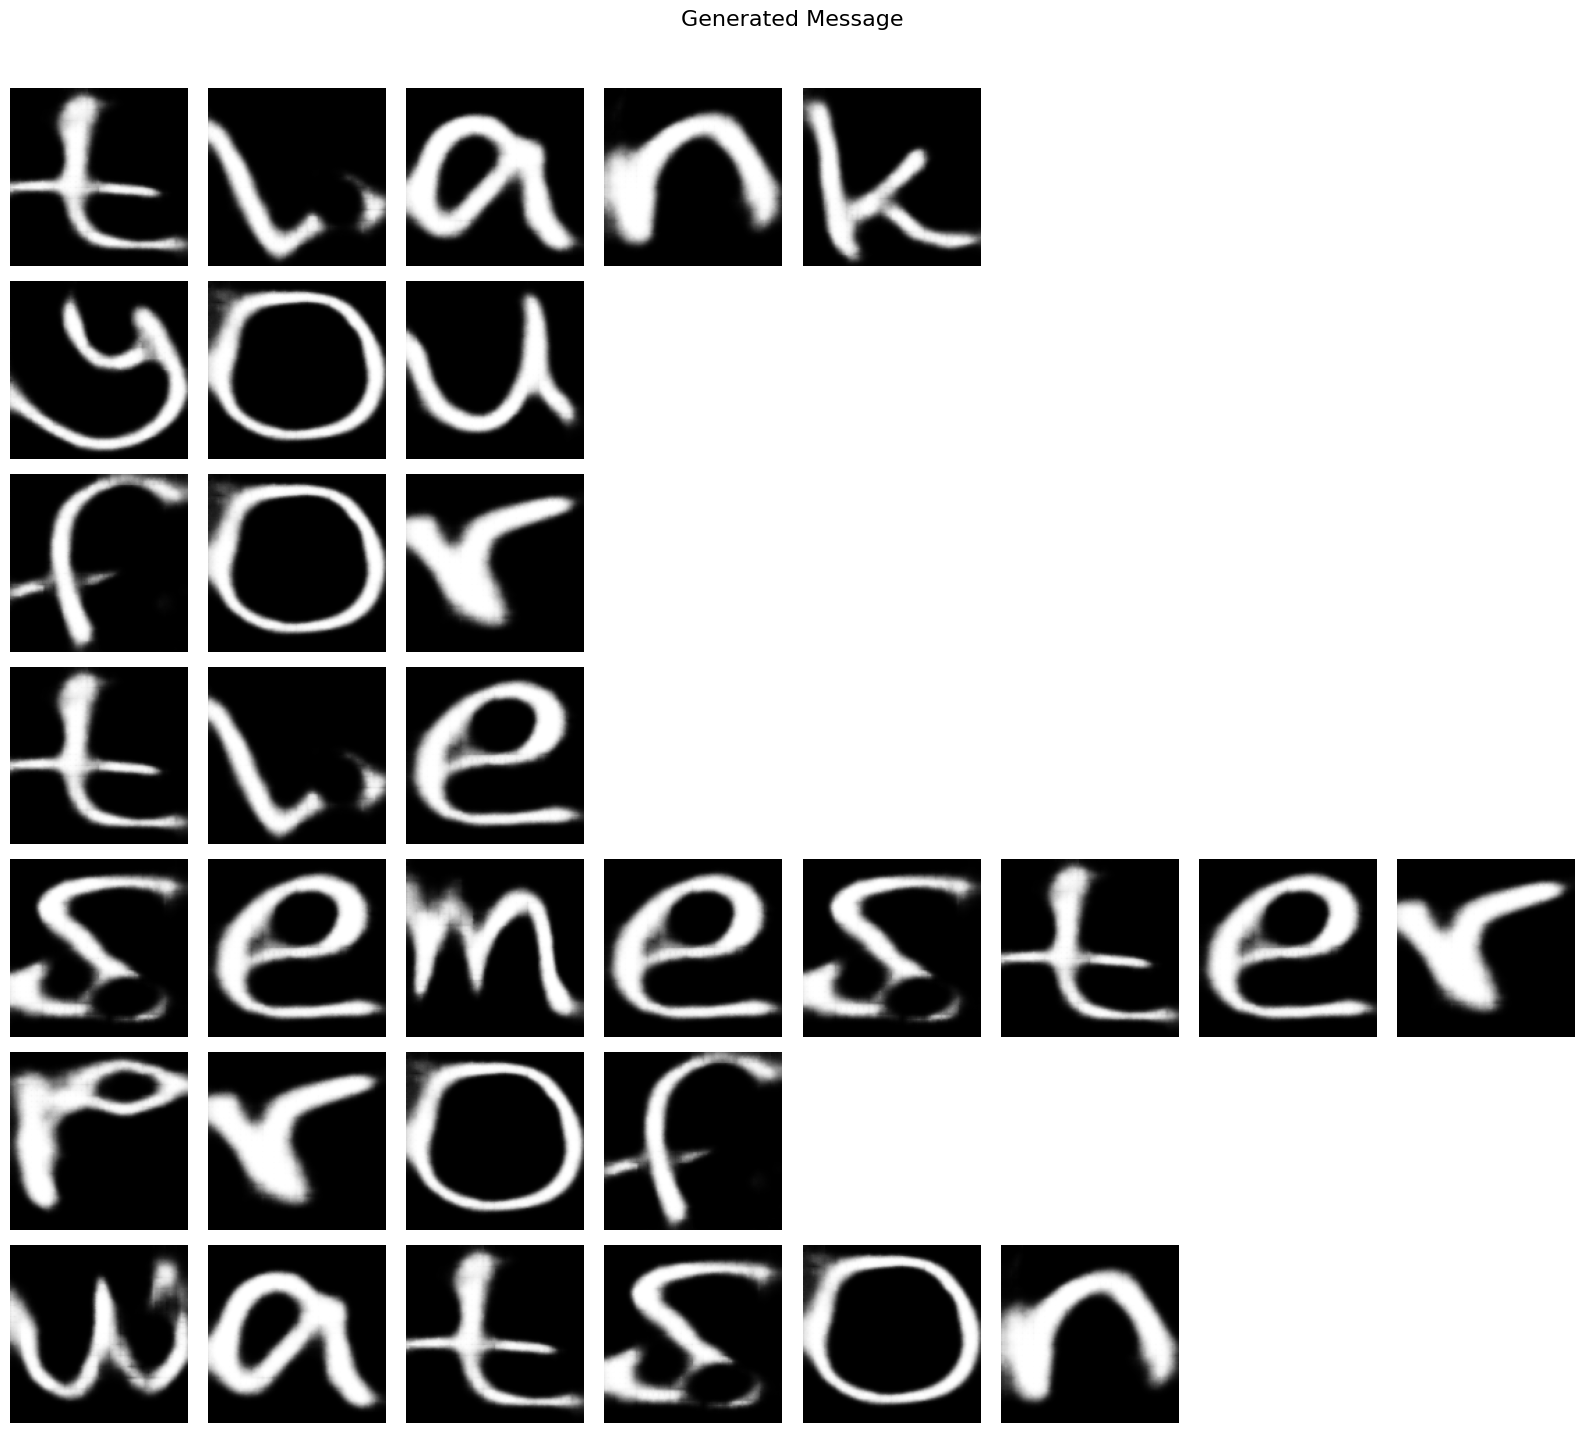

### Reflection, Shortcomings and Future Work:
This report was a deep dive into the world of simple generative models: VAE and GANs. I took a step outside of the class content to learn VAE (extending from the vanilla autoencoders we learned in class). I also learned about GANs, and how they can be used to generate images. I also learned about conditional VAE, and how they can be used to generate specific images. Finally, I applied the principles from dimensionality reduction to the latent space of the VAE to cluster the representations of my handwriting samples and label them in a time-efficient manner. 

Some shortcomings of this report include:

1. I was not able to generate the words I wanted, as the VAE struggled to reconstruct the words when the letters were packed together. This is a problem I would like to tackle in the future.
2. There was not much hyperparameter tuning done for the VAE, GAN and CVAE models. I would like to do more hyperparameter tuning in the future (with more time and computational resources).
3. Finally, I would like to explore more complex models such as transformers and diffusion models, to see how they compare to the VAE and GAN models I have used in this report, now that I have a labelled dataset of my handwriting samples. Specifically, it would be cool to pair this model with a RNN trained on text/essays I have written, to generate new text samples in my handwriting. 

## Introduction

While writing on my Goodnotes app, I noticed that sometimes, red dotted lines appear below my words. This is to indicate that there may have been a spelling error in my writing. The exciting part comes when you tap this dotted word. The app suggests auto-corrected versions of the word and if you choose any of these corrections, it replaces the misspelled handwritten word with the correct version in something that resembles your handwriting. In other words, it tries to generate your handwriting! And so with the knowledge I was gaining from my CS156 class, I looked at this feature and said to myself: 
    
                "I can train a model to generate my handwriting too. How hard can it be?"   

And so for this assignment, I set out to train a model that can generate my handwriting. My dataset is historical notes from my GoodNotes App. I downloaded some of the notes from my GoodNotes app which amounted to over 200 pages of my handwriting. The next step was to process this data into a format that can be represented and used easily for my training.

## Pre-processing

The first step is to download the data from Goodnotes into a folder on  my computer. In this step, it was important to manually filter files that had diagrams/pictures so that they do not contaminate the data training. However, most of my files included equations that was almost impossible to extricate from just text, so I resorted to including those in my dataset. 

Once the data has been downloaded into folders, we can then access and load them using the OpenCV library. 
My goal as mentioned earlier is to generate my handwriting. Specifically, it was to generate words of my handwriting similar to the way it is done in the GoodNotes app. Therefore, I chose to break each handwriting image into individual words (we'll return to this decision shortly). 

OpenCV allows us to take an image and try and break it into its components using its and structuring and contour element methods. This lets us define a shape such as a rectangle or ellipse that we can use to divide the image into segments. The contours lets us different each segment from the other. To get the words I used a rectangle (as words tend to be rectangular) with a kernel size of (30, 1) (I acheived this value after some manual tuning and eye-balling the results -- a better metric might be automatic tuning with the metric being the total number of words expected, but that required a lot more manual counting of words for each page). 


The code for this preprocessing step can be found in **Appendix A (Preprocessing)**. However, an example of the results of this preprocessing step can be seen below.

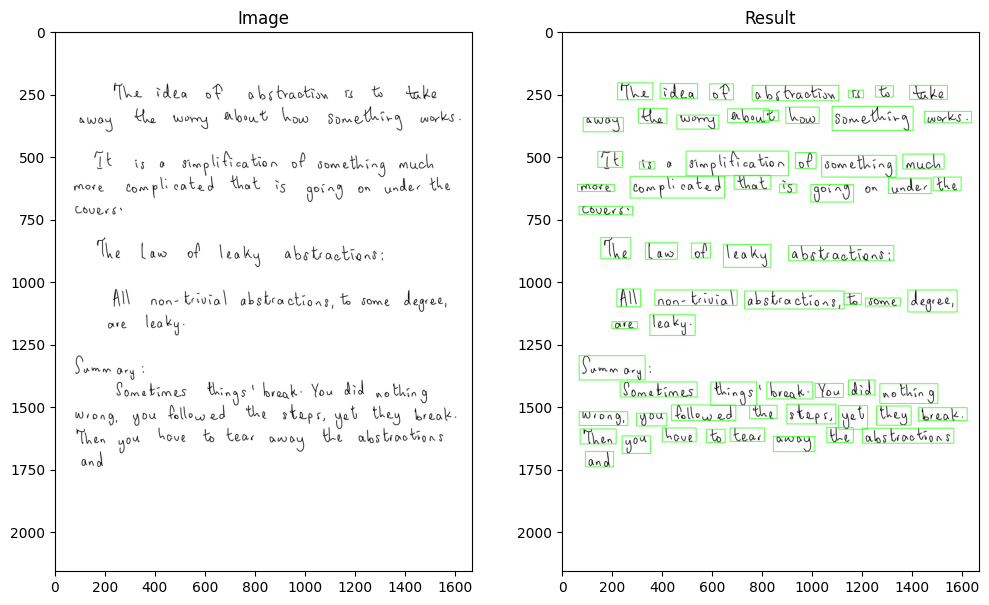

This method as shown above achieved a very good segmentation of the data into words (as measured by eyeballing). In this example nearly all words are captured except the words 'a' (3rd line)  and 'on' (4th line). Additionally the word 'about' on the second line is broken into 'abou' and 't' probably due to the spacing between the letters 'u' and 't'.

#### **A message from the future:**
    
- *Generating full words is tricky. It seems like the model does better on sparse images (not congested as words often are). Could you perhaps give me a dataset of characters to train this model on?*

To create a dataset of just characters, I changed the OpenCV structuring element to an ellipse (as individual characters are not always rectangular as a word might be -- think of a slanted y or l). Additionally I reduced the x value of the kernel to 2 from 30, to become (2, 1). I arrived at the value 2 after some manual tuning. A smaller value allows us to capture smaller segments which we would expect our characters to be in.

The code for this preprocessing step can also be found in **Appendix A (Preprocessing)**. However, an example of the results of this preprocessing step can be seen below.

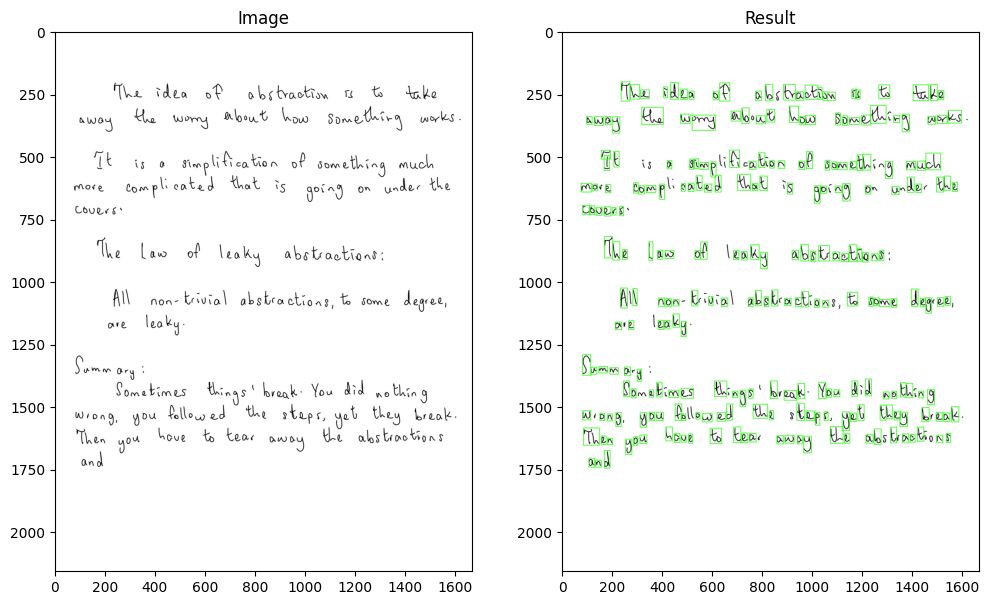

This division does not do quite as well as the word division. In some cases, it captures single characters, but more often that not, it is unable to differentiate two characters due to the style of my handwriting where they are not cleanly separated. A good example is 'Th'. In nearly all cases it groups 't' and 'h' together as a single character. 

Nonetheless, I am going to plough ahead with this data as I could not get a cleaner separation with different tweaks of the kernel size, and the idea was to get less sparse handwriting images (which this achieves).

#### **Note:**

Some of my notes included equations and mathematical notations, and an extra step might consider trying to remove these from the characters / words dataset. I did not do this, because of time constraints and because in a moment of fleeting justification I thought to myself "Well the model gets to learn math too, how can I take that away?"


**Appendix A (Preprocessing)** shows the script for automating the generation of the words and characters from the full dataset of handwritten images.

## Variational Autoencoders

### Analysis:

I've got a dataset of words, a computer, some knowledge and a passion to create something: what can we make of that? To generate new samples of my handwriting, the model needs to somehow learn what makes my handwriting unique. That sounds like a latent variable! This immediately prompts an auto-encoder as a possible useful model here. Specifically, because we are aiming to generate new samples of my handwriting, a special variant of the auto-encoder, called the Variational Autoencoder (VAE) will be more appropriate here. 

Before we go on, it is important to point out something that might have been itching the back of your skull: there are no labels for my dataset. If we'd want to generate my handwriting in the same manner the GoodNotes App does, we'd want to generate a particular word. How would our model know what to generate if it never learned what words map to what representation? 

You're right. It won't be able to. And so we have two options: I go back and label all 15,000+ words in the dataset (either manually or automate the process using some off-the-shelf OCR or recognition model), or I concede some ground on my initial goal for this assignment. Due to time constraints, manually labelling my dataset is off the table. See **Appendix K (Failed Labeling Attempts)** 
                
records some of my attempt to use OCRs such as pytesseract and easyOCR to try and label the words in my dataset: the accuracy was however very poor and could not be used. I also tried using some models I found on kaggle, but this resulted in similarly poor accuracy. This leaves us with the second option.   

Our lack of labels restricts any analysis we can do to unsupervised algorithms, but does not stop our ability to generate samples of my handwriting. Our analysis for this task would be to use a VAE to learn the quirks of my handwriting and using those lessons to generate new samples. I'll go into more details about this approach shortly.

For this analysis, I'll split my dataset (15,483 words) in an 80-20 split with 80% (~12,386 words) for training and 20% (~3,000 words) for testing. Each of these images would be resized and represented as an array or tensor. The code for this preprocessing step can be found in **Appendix B (labeled 'VAE Setup')**.

I use an input shape of (128, 128) as a balance between efficiency and allowing a high enough resolution to allow the model learn properly.

### Model selection: 

An auto-encoder is an unsupervised machine learning model that essentially learns to encode an input data into a lower-dimensional space through down-sampling and then decode that lower-dimensional data representation (also known as a latent variable) back into the original image. The former part of the model is called the encoder and the latter part is the decoder. A major benefit of this approach is that you can basically compress any input data into a lower dimensional state, while maintaining the essence of the data. In other words, the model is forced to learn the essential features of the data so that it can reconstruct it later. 

A variational auto-encoder is an auto-encoder with a twist. With the vanilla auto-encoder, the goal is to try and reconstruct the original image from the encoded latent variable. It's a direct mapping: there is no way to generate new, but similar images. A variational auto-encoder allows us to do that. Instead of just encoding the latent variable, it encodes a guassian probability distribution (defined by the mean and the variance). Hence, when we try to decode an image, we sample a latent variable from this distribution. Given the properties of a guassian, this variable would very likely be similar to the 'true' latent variable, but it would still be different. Therefore, the reconstructed image would be essentially a 'new' sample that closely resembles the original input data. 

How would this actually work? What's the math behind it?
 
1) The input data is passed into the input layer of a defined network. This layer is then propagated through hidden layers (often convolutional layers) that have continuously fewer neurons in them (essentially forcing the same input data to be represented in fewer and fewer dimensions). This would come to a head in the bottle neck layer. This is where the model is represented in the dimension you defined for the latent space (latent_dim).
 
2) The bottle-neck layer would then have a fully connected layer to learn the mean (μ) and log variance (log σ²) of the latent space distribution. These parameters define a multivariate Gaussian distribution from which we can sample our latent vector z.

3) To generate the latent vector z, we use the reparameterization trick: z = μ + σ * ε, where ε is sampled from a standard normal distribution N(0,1). This trick allows backpropagation through the random sampling process.

4) The decoder then takes this latent vector z and maps it back to the original input space through a series of upsampling layers (often transpose convolutions), essentially learning to reconstruct the original input from the compressed representation.

5) The model is trained by minimizing two components:
    - Reconstruction loss: How well the decoder can reconstruct the original input
    - KL divergence loss: Forces the learned latent distribution to be close to a standard normal distribution

This architecture allows us to not only compress and reconstruct images, but also generate new ones by sampling from the learned latent space distribution.


The VAE basically follows the below mathematical algorithm to learn the encodings and decodings:

1. $i \leftarrow 0$
2. while i < epochs **do**
3. Sample a batch of data points ${x^{(1)}, \dots, x^{(m)}}$ from the dataset $p_D(x)$
4. Compute $\mu_\phi^{(k)}$ and $\log \sigma_\phi^{2(k)}$ for each $x^{(k)}$ using the encoder:
   $$\mu_\phi^{(k)}, \log \sigma_\phi^{2(k)} \leftarrow \text{Encoder}(x^{(k)}; \phi)$$
5. Sample $\epsilon^{(1)}, \dots, \epsilon^{(m)}$ from standard normal distribution $\mathcal{N}(0, 1)$
6. Reparameterize latent variable:
   $$z^{(k)} \leftarrow \mu_\phi^{(k)} + \sigma_\phi^{(k)} \cdot \epsilon^{(k)}$$
7. Decode to reconstruct $x^{(k)}$:
   $$\hat{x}^{(k)} \leftarrow \text{Decoder}(z^{(k)}; \theta)$$
8. Compute reconstruction loss for the batch:
   $$\mathcal{L}_{\text{recon}} \leftarrow -\frac{1}{m} \sum_{k=1}^m \log p_\theta(x^{(k)} | z^{(k)})$$
9. Compute KL divergence for the batch:
   $$\mathcal{L}_{\text{KL}} \leftarrow \frac{1}{2m} \sum_{k=1}^m \Big( 1 + \log \sigma_\phi^{2(k)} - (\mu_\phi^{(k)})^2 - \sigma_\phi^{2(k)} \Big)$$
10. Compute total loss:
    $$\mathcal{L} \leftarrow \mathcal{L}_{\text{recon}} + \beta \mathcal{L}_{\text{KL}}$$
11. Perform SGD updates for $\theta$ and $\phi$:
    $$\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}, \quad \phi \leftarrow \phi - \eta \nabla_\phi \mathcal{L}$$
12. $i \leftarrow i + 1$
13. **end while**


The code implementing this algorithm can be found in **Appendix C (labelled 'VAE Model')** and **Appendix D (labelled 'VAE Training')**.

### Training (Words Dataset):

Below is a summary of the model's architecture and the training process.

**Model: Encoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">160</span> │ input_layer_4[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">16</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">4,640</span> │ conv2d_6[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">32</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">18,496</span> │ conv2d_7[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)     │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_8[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)     │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)       │  <span style="color: #00af00; text-decoration-color: #00af00">8,389,120</span> │ flatten_2[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_4[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_4[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ z_mean[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],     │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Sampling</span>)          │                   │            │ z_log_var[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>
</div>
Total params: 8,478,080 (32.34 MB)

**Model: Decoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)             │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)          │     <span style="color: #00af00; text-decoration-color: #00af00">1,064,960</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Reshape</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">36,928</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">18,464</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)   │         <span style="color: #00af00; text-decoration-color: #00af00">4,624</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)    │           <span style="color: #00af00; text-decoration-color: #00af00">145</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
</div>

Trainable params: 1,125,121 (4.29 MB)

### Results:

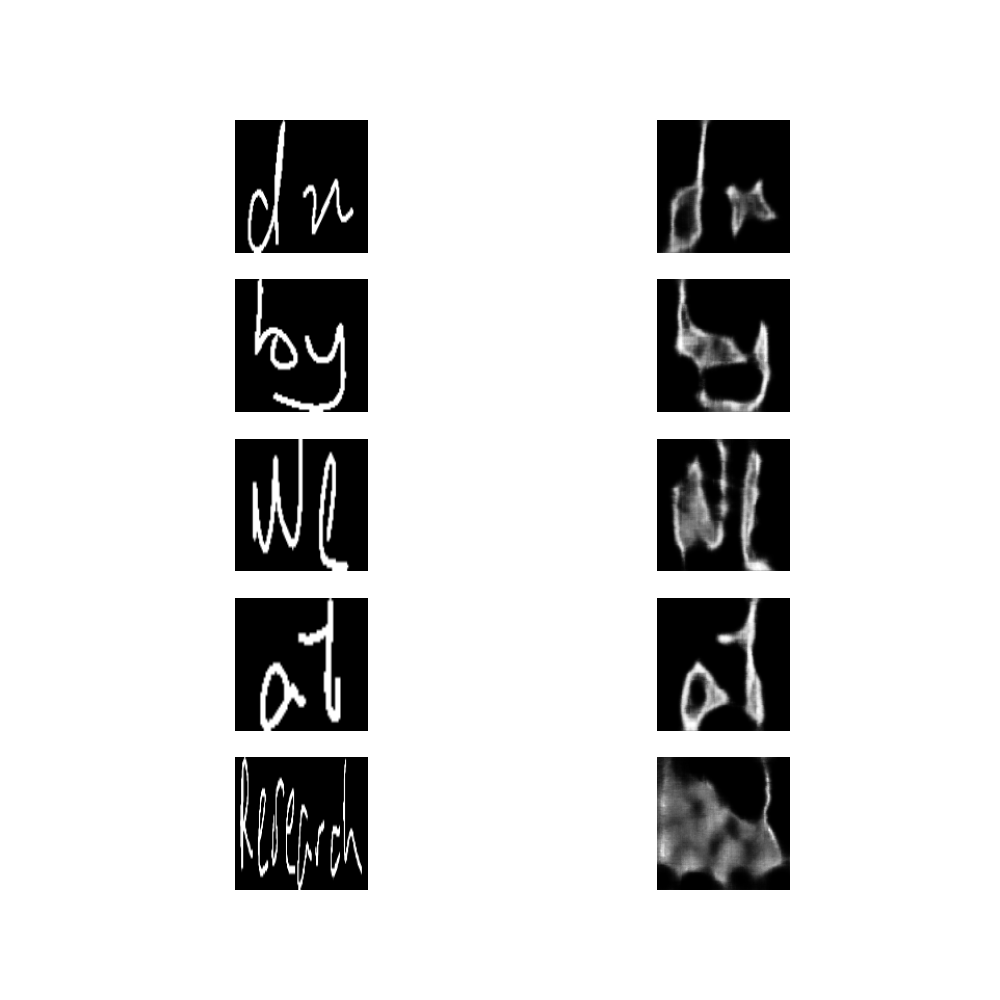

### Interpretation:

From the results displayed above, it is clear that the longer the word (more compact the pixel value is on the image), the worse our model performs, while it does better when there is more space (less compact) between characters. Why might this be so? The first is to consider the hyper-parameters. Perhaps the model would do better if it ran for more epochs? We can visualize the loss from the training and see if it has begun to converge or it would benefit from more training epochs? See **Appendix D** for the loss plots code. 

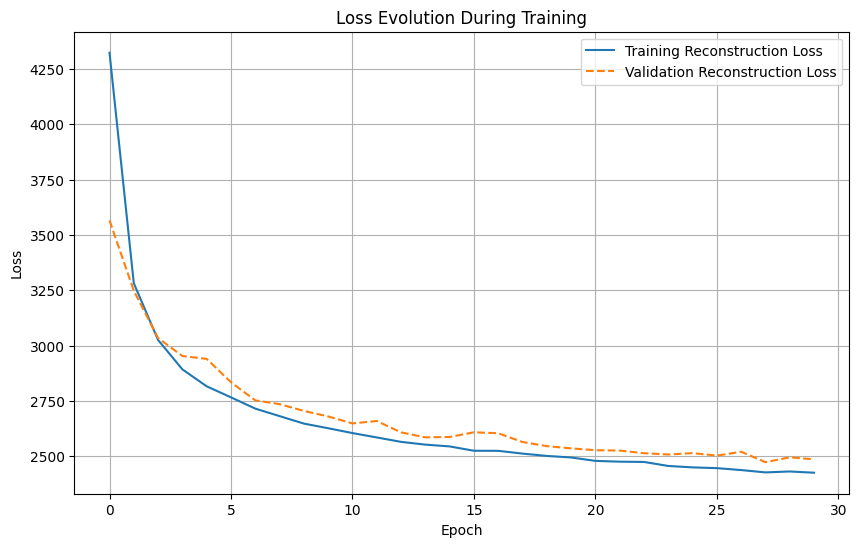

The model seems to be learning well with both the training and validation reconstruction loss decreasing with each epoch. The loss had begun to converge however, and so we can safely project that the loss would not decrease by much if we trained the model with more epochs. We must look elsewhere for the cause of the poor reconstruction capabilities of our model. There are several factors that might influence this:

 1) Hyper-parameters: Perhaps the information in pixel-dense images (as in longer words) cannot be fully captured in the latent-dimensions. Perhaps using larger dimension for my latent space might improve the model's performance

 2) Dataset: My dataset is quite unstructured. Words could be as short as 'a' or as long as 'research' (or even longer) in the same 128*128 pixel grid. It is possible that my dataset has a lot more shorter words than longer words in the dataset, making the model do worse on these longer, higher density pictures. Additionally, it might just be that it is harder to see individual characters in longer words that are tightly clustered (which might explain how words with space in-between characters still do well). Hence the representation of these words lose the fine details of the interactions between the characters, but still tries to keep the overall structure of the whole word.


 These problems are hard to explore and deal with. For the hyper-parameters, because of how long it takes to run the model (about 2 hours), it is quite intractable to carry out cross-validation or explore the hyper-parameters of the model. It is also quite hard to measure the space between characters and the length of each word in the dataset to ensure that spaced and dense words are properly balanced. However, one way we can validate the second fear is to train the model on just characters (rather than words). We would expect the model to do much better on just characters than words (given that the information density is avoided). Let's try this below. 

### Training (Characters Dataset):

Below is a summary of the model's architecture and the training process.

**Model: Encoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">160</span> │ input_layer_8[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">16</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">4,640</span> │ conv2d_12[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">32</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">18,496</span> │ conv2d_13[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)     │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_14[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)     │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)       │  <span style="color: #00af00; text-decoration-color: #00af00">8,389,120</span> │ flatten_4[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_8[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_8[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ z_mean[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],     │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Sampling</span>)          │                   │            │ z_log_var[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>
</div>
Trainable params: 8,478,080 (32.34 MB)


**Model: Decoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)             │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)          │     <span style="color: #00af00; text-decoration-color: #00af00">1,064,960</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Reshape</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">36,928</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">18,464</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)   │         <span style="color: #00af00; text-decoration-color: #00af00">4,624</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)    │           <span style="color: #00af00; text-decoration-color: #00af00">145</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
</div>

 Trainable params: 1,125,121 (4.29 MB)


### Results: 

**Original images vs generated images:**

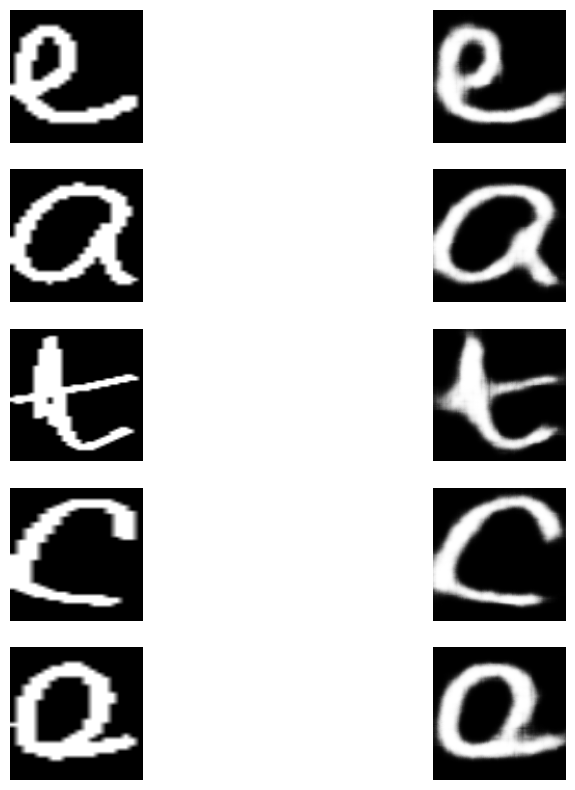

This clearly does a lot better than the dataset with just words. While the generated images are blurrier than the original image, it is still visible and clear what the letters are. We can also visualize the loss function evolution during the training. The code for the training and loss plots can be found in Appendix D (VAE Training)

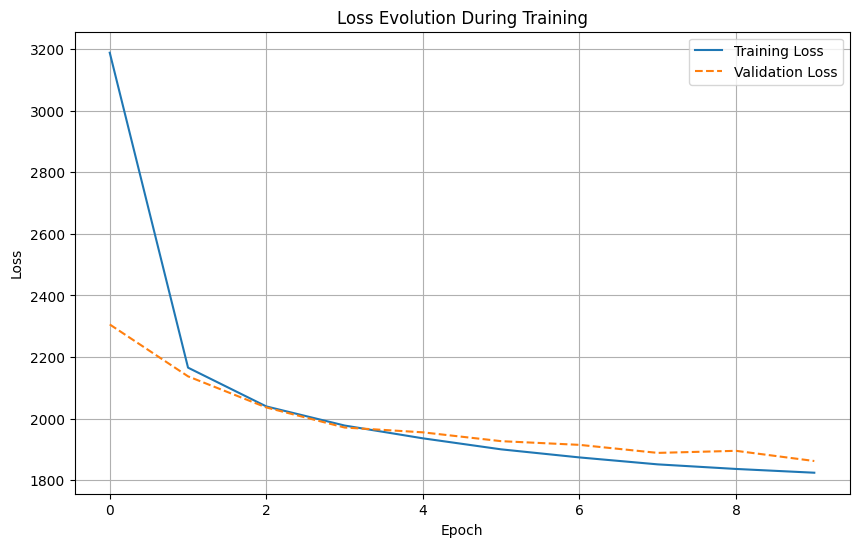

### Generating a new image

Now that we have a trained variational auto-encoder, we should be able to generate new samples of my handwriting. To do this we need to sample a variable from the latent space and try to predict the value. Let's take a random value. You can see the code for this in Appendix E (VAE Generation)

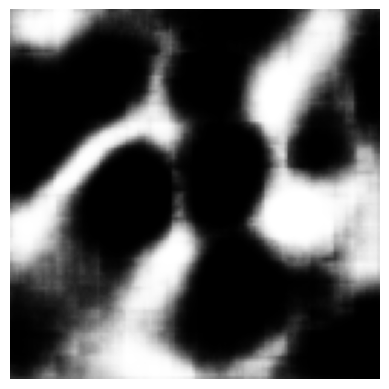

Uh-oh, the image doesn't look quite good. In fact, it doesn't seem to resemble any image that we know. Why might that be? Let's visualize and explore the latent space to understand this better. 

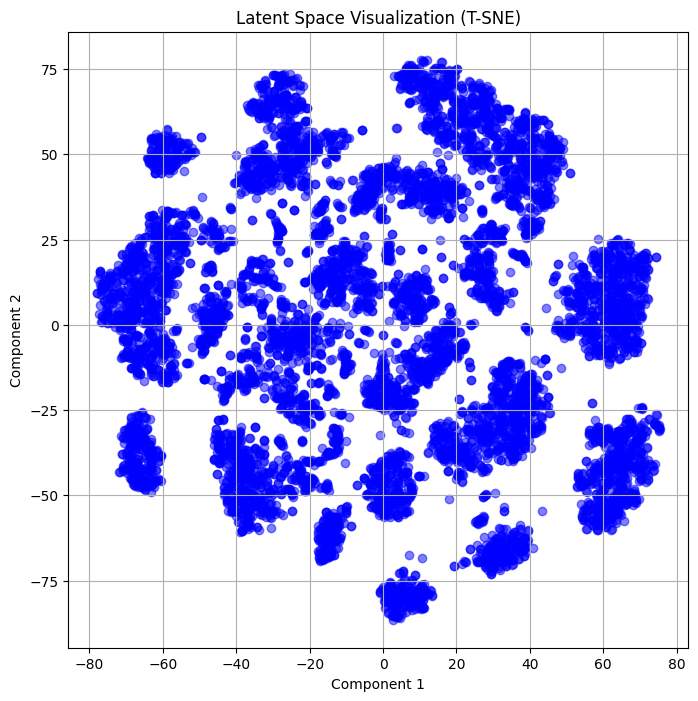

It seems like the latent space is made up of clusters as we might expect. The VAE has learned to group certain characters together. This is great. However, this tells us that we must sample smartly from this latent space in order to hit highly congregated sections of the space. Specifically, we can try three different ways to sample from this space. 

1) **KDE sampling**: This stands for the kernel density sampling. Specifically, we try to ensure that the random latent vector we sample comes from a point where there are many other values. This increases the chances that this latent variable actually decodes to a character we can recognize. 

2) **KMeans sampling**: Here we use the K-Means algorithm to identify the different clusters and their centers. And now instead of randomly sampling, we can randomly select a cluster center (this should correspond to some character) and then add random noise to it. This ensures that we generate a recognizable character (given that the clusters themselves decode to a recognizable character)

3) **Interpolated sampling**: This is fun because we can follow a linear path from one cluster to another. Due to the nature of the VAE (specifically the fact that we used a gaussian distribution), each point in the latent space must be decode to an image. Therefore, when we take a 'walk' from one cluster to another, we can see the intermediate images as they warp themselves from one character to the other. 

All three of these methods are implemented in **Appendix E (VAE Generation)**. 

**KDE Sampling**

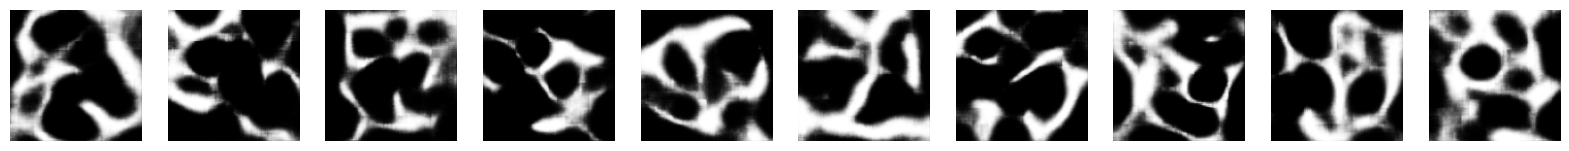

**KMeans Sampling**

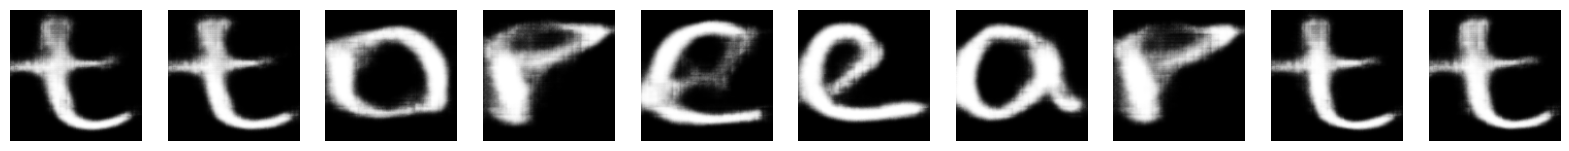

**Interpolated Sampling**

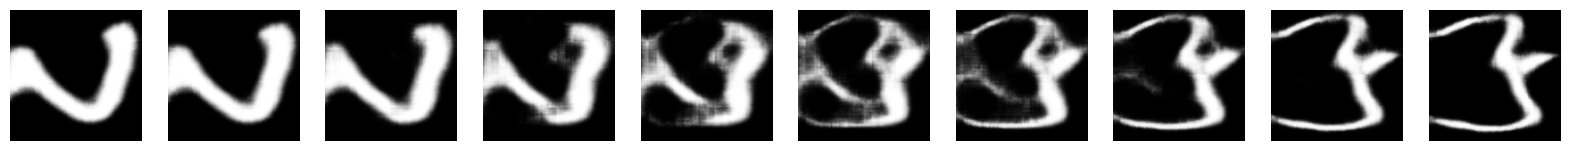

The KDE sampling still does not provide an interpretable character. This might indicate the presence of uninterpretable characters in my dataset that the latent space have learnt. This characters must exist close to each other in the latent space. This error we have stumbled upon also underscores a strategy for identifying outliers within a certain dataset.


The cluster and interpolated sampling on the other hand do a better job of generating interpretable characters. Specifically the interpolated sampling seems to be going from the character 'v'(?) to '}'. The model must be learning some features of the characters that puts them close to each other in the latent space (perhaps the vertical stroke of the 'v' is similar to the vertical stroke of the '}'). 

## Semi-supervised labelling

This latent exploration offers an opportunity to fix a drawback in our approach that was noticed previously. We see that similar characters tend to congregate into clusters. Using this observation, we can quickly label our dataset, by simply labelling clusters. The idea is that all the images in a given cluster would be samples of the same character, hence should all have the same label. 

Given that I have already trained the VAE, I can carry out this semi-supervised labelling of the dataset using the latent space of the already trained character VAE. To do this, I'll sample from the different clusters in the space. I'll sample about 3-4 images from each cluster and identify what character that is. I will then proceed to make a generalization and label each image in that cluster with the identified cluster. 

For clustering, I use sklearn's DBSCAN module. This stands for the Density Based Spatial Clustering of Applications with Noise. This is a clustering algorithm that groups together points that are close to each other. 

**How does DBSCAN work?**

DBSCAN works by first identifying the density of points in the dataset. 

- It does this by first identifying the points that are close to each other using the euclidean distance. - The eps parameter controls the maximum distance between two points to be considered close. Higher values of eps will result in more points being considered close to each other and hence less clusters. 
- It then groups these points together into clusters. 
- The algorithm then proceeds to identify the points that are not close to any other points. These points are called noise points. 

Now that all the clusters have been identified, I manually display five images from each of these clusters and label them. This automatically labels the clusters and all the images in the cluster. After this is done for all the clusters, we can then save the images and their corresponding labels to the dataset directory. 

At the end of the process, I had a folder with subfolders corresponding to a single character. Each subfolder contains images that are decoded from the latent space that have been labeled as that character. I can now use these images and their corresponding labels to train a classifier to label the images. In total I had about 6000 images in the dataset.

The code for the semi-supervised labelling can be found in **Appendix F (Semi-Supervised Labelling)**


## Conditional Variational Auto-Encoder

### Some Data Exploration

First let's visualize the dataset and the distribution of the images into the different classes. In order for our model to be able to learn the different classes, we need to ensure that the classes are well distributed across the dataset.

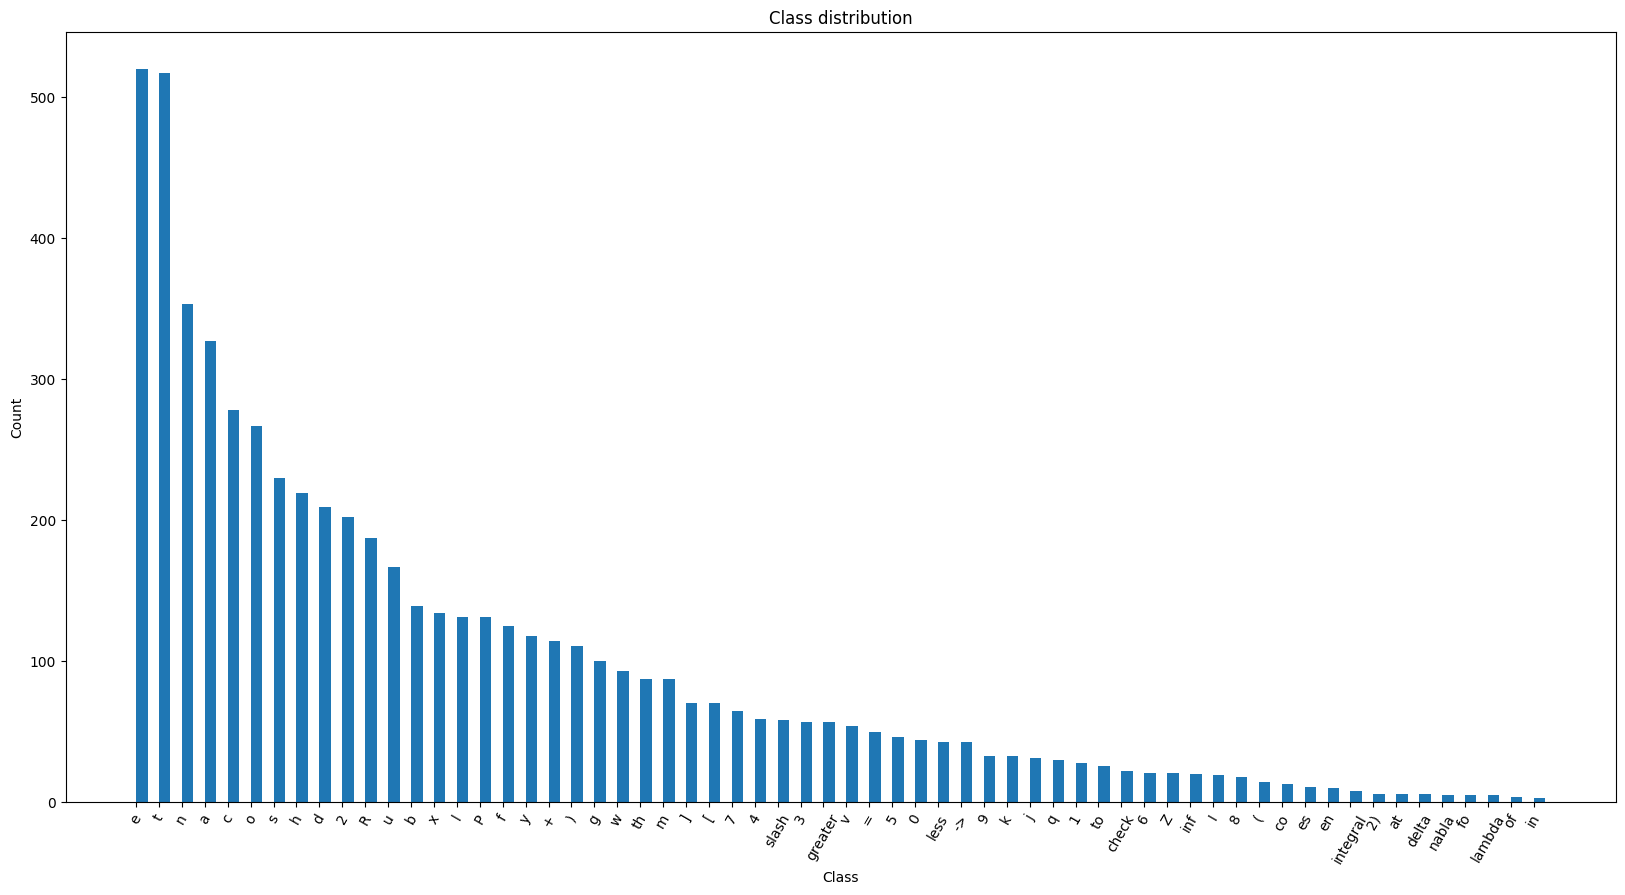

It is very clear that the dataset is imbalanced. This is a problem because the model will learn to predict the majority class more often than the others and we'd rather that the model generalizes to all the classes well. 

To fix this, we can use data augmentation to artificially increase (upsample) the number of images in the minority classes. We also downsample the majority class to ensure that the dataset is balanced. This will help the model to learn the different classes better. For simplicity, I removed all the phrase like labels such as 'co' 'es' etc, and also remove all the special characters. This is because these classes have too few samples to be useful. Then I undersample from the really high classes and include augmentation for the smaller classes. 

The code for loading the dataset, generating the plots and the data balancing can be found in **Appendix G (CVAE Data Exploration)**. After running this code, we can see that the dataset is now more balanced (the range has gone from (5, 500) to (30, 300)). After cleaning, we have 43 different classes with all the English alphabets and digits included.

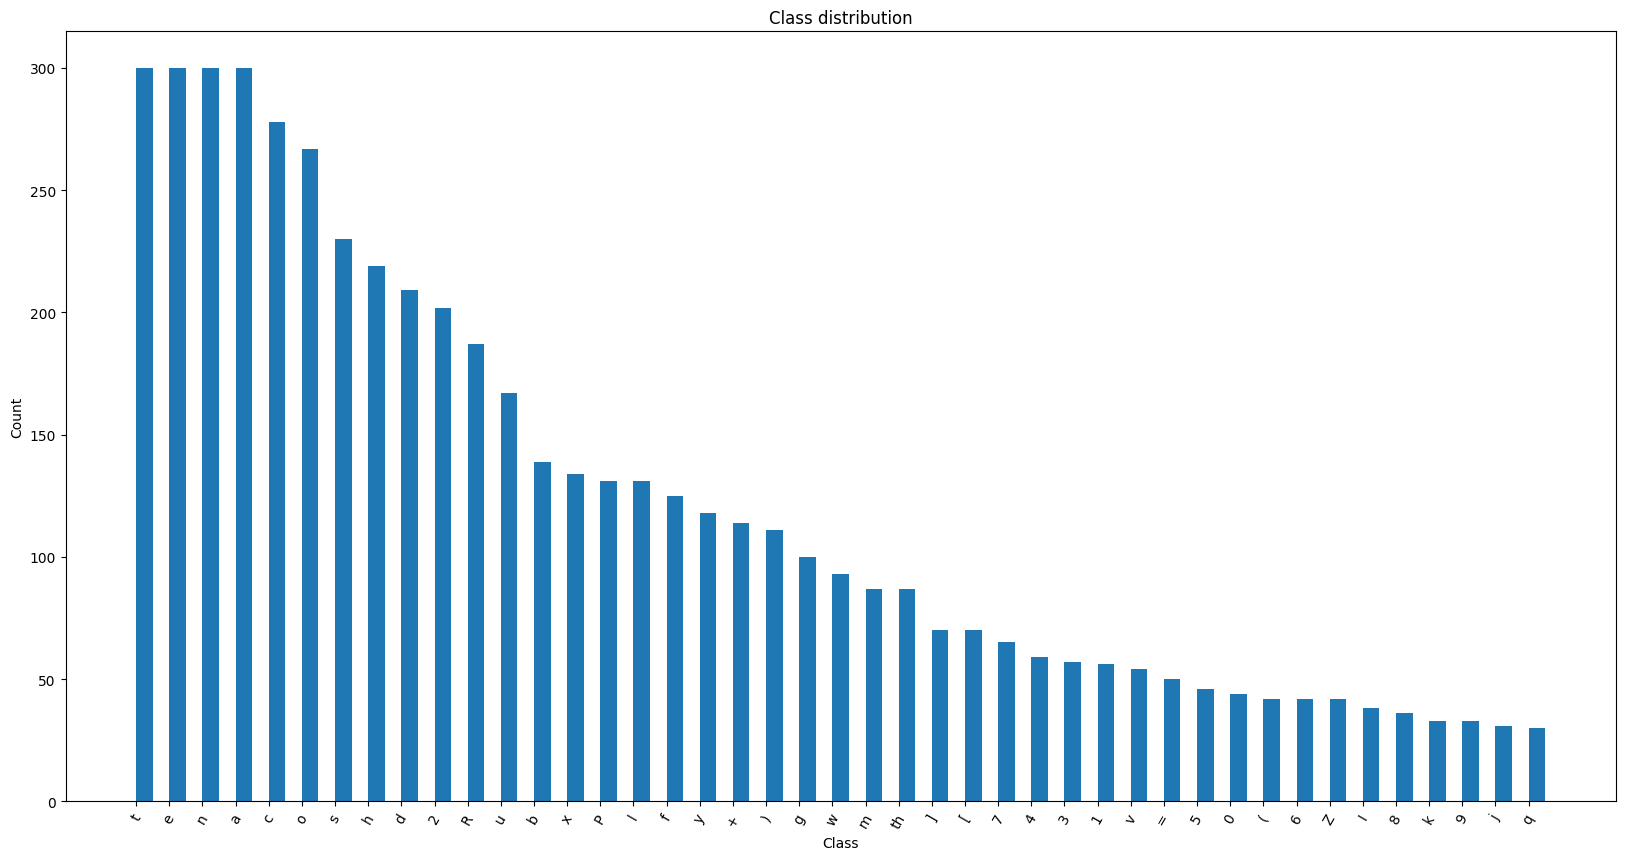

### Training the Conditional Variational Auto-Encoder

Training the CVAE is very similar to training the VAE. The only difference is that we now have an additional input layer that takes in the label of the image. This label is then used to condition the generation of the image. This label input and image input are then concatenated and passed into the encoder and decoder the same way we did for the VAE. See **Appendix H (CVAE Training)** for the code. 

**Model: Encoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">160</span> │ input_layer_72[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">16</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">4,640</span> │ conv2d_60[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">32</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">18,496</span> │ conv2d_61[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)     │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_62[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_73      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">43</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16427</span>)     │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ flatten_20[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │                   │            │ input_layer_73[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)       │  <span style="color: #00af00; text-decoration-color: #00af00">8,411,136</span> │ concatenate_35[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_35[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │     <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ dense_35[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_19         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ z_mean[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],     │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Sampling</span>)          │                   │            │ z_log_var[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>
</div>

Total params: 8,500,096 (32.43 MB)

**Model: Decoder**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_74      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_75      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">43</span>)        │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">107</span>)       │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ input_layer_74[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │                   │            │ input_layer_75[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16384</span>)     │  <span style="color: #00af00; text-decoration-color: #00af00">1,769,472</span> │ concatenate_36[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ dense_36[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Reshape</span>)           │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_42 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">18,464</span> │ reshape_15[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)   │ <span style="color: #00af00; text-decoration-color: #00af00">32</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_43 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">4,624</span> │ conv2d_transpose… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)   │ <span style="color: #00af00; text-decoration-color: #00af00">16</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │        <span style="color: #00af00; text-decoration-color: #00af00">145</span> │ conv2d_transpose… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)   │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>
</div>

Total params: 1,792,705 (6.84 MB)

### Plotting the loss evolution

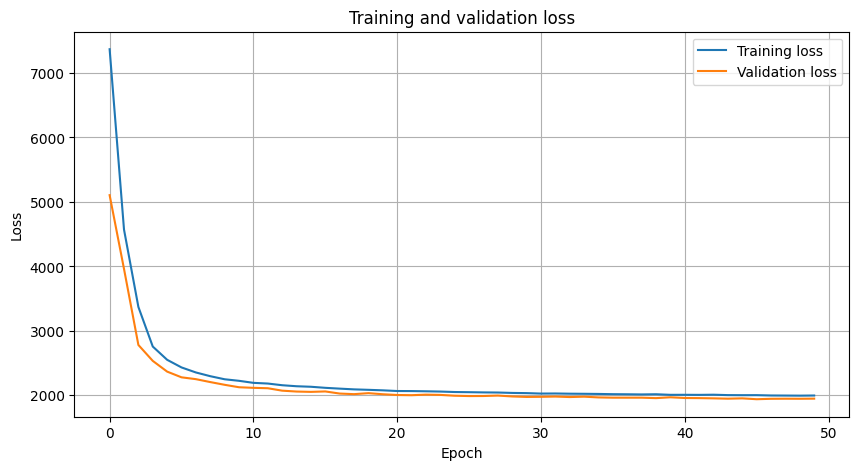

### Generating new samples of handwriting

### Gaussian Mixture Model (GMM)

Again, it is necessary to sample intelligently from the latent space to generate new samples of handwriting. First, we get the latent representation of the dataset using the encoder of the CVAE we trained. 

Next, we fit a Gaussian Mixture Model (GMM) to the latent space to get the distribution of the latent space. In order words, we classify the latent space into different clusters using the Expectation Maximization algorithm of the GMM. 

A short summary of how the GMM works is as follows:

1. The model starts by initializing three key parameters for each component:
    - Mixing coefficients (π): Probability of each component (initialized uniformly)
    - Means (μ): Centers of Gaussian components (initialized randomly from data points)
    - Covariances (Σ): Shape and orientation of components (initialized as identity matrices)

2. Expectation Step: The E-step calculates the "responsibility" (γ) that each component takes for explaining each data point. 

    - For each data point x_i and component k,
        1. Calculate p(x_i|k) using the Gaussian probability density function
        2. Calculate γ_ik = (π_k p(x_i|k)) / Σ_j(π_j p(x_i|j))

    - This gives us the probability that each data point belongs to each component

3. Maximization Step: The M-step updates the model parameters using the calculated responsibilities:

    a. Update the mixing coefficient π_k = (1/N) * Σ_i(γ_ik)
    b. Update the mean μ_k = (1/Σ_i(γ_ik)) * Σ_i(γ_ik * x_i)
    c. Update the covariance Σ_k = (1/Σ_i(γ_ik)) * Σ_i(γ_ik * (x_i - μ_k).T * (x_i - μ_k))

4. Calculate the log-likelihood of the data under the current model parameters; L = Σ_i(log(Σ_k(π_k * p(x_i|k)))). This measures how well the model fits the data.

5. Repeat steps 2-4 until convergence.

After the GMM is trained, we can use the model to generate new samples of handwriting as each cluster should represent a character. We simply pass in the character (label) we want to generate (as a one-hot encoded vector) and sample from the GMM to get a latent vector of the character. We can then decode the latent vector to get the new sample of handwriting.

The code for the GMM and generating samples can be found in **Appendix I (Generate Samples)**

Below is the plot of the latent space of the GMM with the clusters colored by the character they represent.

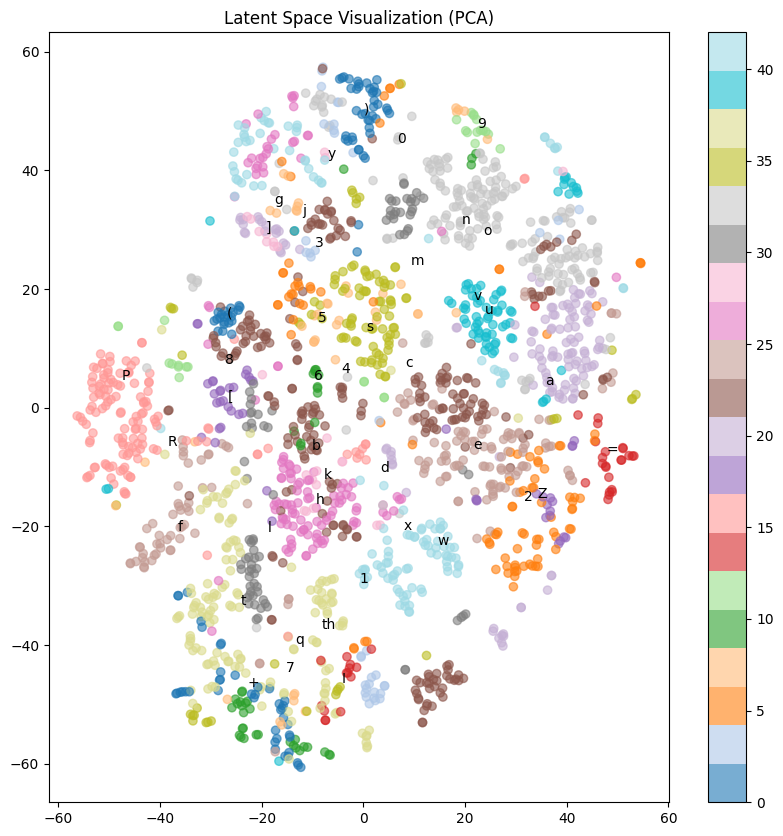

Finally, below is the generated handwriting of the character 'a'

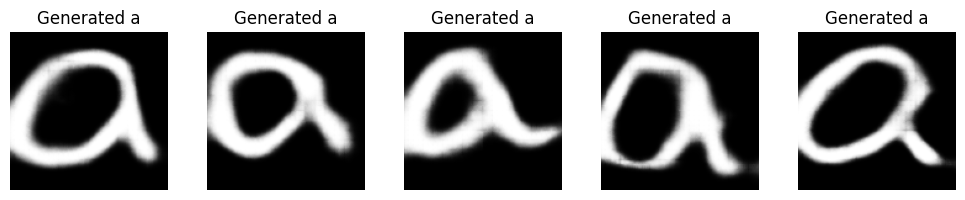



## GAN

### Analysis
Another approach to generating handwriting is using a Generative Adversarial Network (GAN). A GAN consists of two neural networks that work against each other in a minimax game - a generator that creates fake samples and a discriminator that tries to distinguish real samples from fake ones.

The generator takes random noise as input and transforms it into new images that aim to be indistinguishable from my real handwriting samples. Meanwhile, the discriminator acts as a binary classifier, learning to identify whether an image is real (from the training set) or fake (created by the generator).

During training, these networks engage in an adversarial process:
1. The generator tries to create increasingly realistic fake images to fool the discriminator
2. The discriminator tries to get better at detecting fake images
3. This competition drives both networks to improve - the generator produces more convincing fakes while the discriminator becomes a better detective

The training process follows this mathematical framework:
    - The discriminator maximizes: E[log(D(x))] + E[log(1-D(G(z)))]
    - The generator minimizes: E[log(1-D(G(z)))]
Where:
    - D(x) is the discriminator's estimate of the probability that real data x is real
    - G(z) is the generator's output given random noise z
    - D(G(z)) is the discriminator's estimate of the probability that fake data G(z) is real

At convergence, if training is successful, the generator will produce samples that are nearly indistinguishable from real handwriting, effectively learning the underlying distribution of the training data.


The mathematical algorithm for this learning process is as follows:

GAN Algorithm

1. Initialize iteration counter $i = 0$
2. **while** $i < \text{epochs}$ **do**:
3. &emsp; **for** each batch of real images $\{x^{(1)}, ..., x^{(m)}\}$:
4. &emsp;&emsp; Sample minibatch of latent variables $\{z^{(1)}, ..., z^{(m)}\}$ from prior $p_Z(z) \sim \mathcal{N}(0,1)$
5. &emsp;&emsp; Generate fake images using Generator:
    &emsp;&emsp; $\hat{x}^{(k)} = \text{Generator}(z^{(k)}; \theta_G)$
6. &emsp;&emsp; Compute Discriminator predictions:
    &emsp;&emsp; $D_{\text{real}}^{(k)} = D(x^{(k)}; \theta_D)$
    &emsp;&emsp; $D_{\text{fake}}^{(k)} = D(\hat{x}^{(k)}; \theta_D)$
7. &emsp;&emsp; Compute Discriminator loss:
    &emsp;&emsp; $\mathcal{L}_D = -\frac{1}{m} \sum_{k=1}^m[\log(D_{\text{real}}^{(k)}) + \log(1 - D_{\text{fake}}^{(k)})]$
8. &emsp;&emsp; Update Discriminator parameters via SGD with learning rate $\eta_D$:
    &emsp;&emsp; $\theta_D = \theta_D - \eta_D \nabla_{\theta_D} \mathcal{L}_D$
9. &emsp; **end for**
10. &emsp; Sample new minibatch of latent variables $\{z^{(1)}, ..., z^{(m)}\}$ from $p_Z(z) \sim \mathcal{N}(0,1)$
11. &emsp; Generate fake images using Generator:
     &emsp; $\hat{x}^{(k)} = \text{Generator}(z^{(k)}; \theta_G)$
12. &emsp; Compute Generator predictions:
     &emsp; $D_{\text{fake}}^{(k)} = D(\hat{x}^{(k)}; \theta_D)$
13. &emsp; Compute Generator loss:
     &emsp; $\mathcal{L}_G = -\frac{1}{m} \sum_{k=1}^m \log(D_{\text{fake}}^{(k)})$
14. &emsp; Update Generator parameters via SGD with learning rate $\eta_G$:
     &emsp; $\theta_G = \theta_G - \eta_G \nabla_{\theta_G} \mathcal{L}_G$
15. &emsp; $i = i + 1$
16. **end while**




### Model Architecture and Training

All the code for the GAN can be found in **Appendix J (GAN)**. See the Create GIF section for a cool GIF of the training states (from noise to the character images)

Model: Generator

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12544</span>)          │     <span style="color: #00af00; text-decoration-color: #00af00">1,254,400</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12544</span>)          │        <span style="color: #00af00; text-decoration-color: #00af00">50,176</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalization</span>)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">LeakyReLU</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12544</span>)          │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Reshape</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">256</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │       <span style="color: #00af00; text-decoration-color: #00af00">819,200</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │           <span style="color: #00af00; text-decoration-color: #00af00">512</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalization</span>)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (<span style="color: #0087ff; text-decoration-color: #0087ff">LeakyReLU</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │       <span style="color: #00af00; text-decoration-color: #00af00">204,800</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │           <span style="color: #00af00; text-decoration-color: #00af00">256</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalization</span>)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (<span style="color: #0087ff; text-decoration-color: #0087ff">LeakyReLU</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">28</span>, <span style="color: #00af00; text-decoration-color: #00af00">28</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)      │         <span style="color: #00af00; text-decoration-color: #00af00">1,600</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
</div>

Total params: 2,330,944 (8.89 MB)


**Model: Discriminator**

<div style="font-size: 0.8em; width: 100%; overflow-x: auto;">
    <pre style="margin: 0;">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │         <span style="color: #00af00; text-decoration-color: #00af00">1,664</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">LeakyReLU</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">14</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │       <span style="color: #00af00; text-decoration-color: #00af00">204,928</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">LeakyReLU</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">7</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">6272</span>)           │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │         <span style="color: #00af00; text-decoration-color: #00af00">6,273</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
</div>
Total params: 212,865 (831.50 KB)

### Results and Loss Evolution Plots:

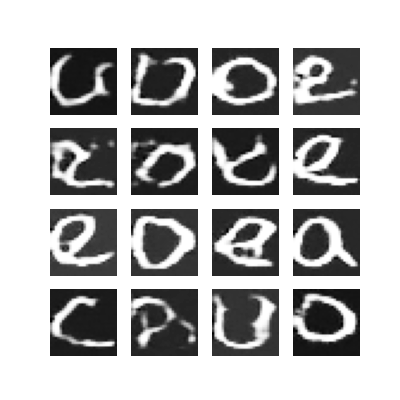

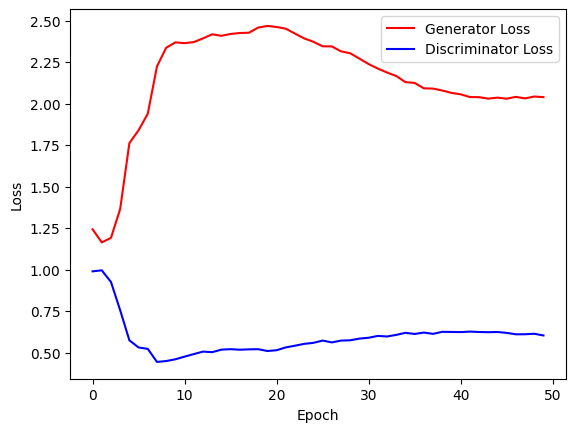


### Intepretation and comparison with the VAE:

The characters generated by the GAN, seem to resemble legible character. You can make out an a, o, e, u, c and a t (if you squint properly). Some of the characters are not quite as legible (such as the very first letter). Overall, the quality of the GAN and the VAE are comparable. Although the initial constraints of the VAE remain. Here, we can not directly control what character would be generated by the GAN.  

The loss function evolution during the training shows us that our GAN seemed to converge at about 2.1 for the generator and 0.6 for the discriminator. These are okay results as GANs are notorious for failing to converge. We see different (almost mirror) losses for the discriminator and generator because of the adversarial nature of both networks: the better the generator (lower loss), the harder it is for the discriminator to go its job (hence higher loss) and vice-versa. 

## Conclusion:

"How hard can it be?" Pretty hard. But by going on this journey, we have learned and explored Variational Autoencoders and GANs as well as how to sample and label data intelligently from a latent space. We've learned the constraints of supervised learning and the lack of labeled data. We've learned to adapt our approach to still meet our goals. Overall, we successfully met the starting goal of being able to generate new samples of my handwriting. 

### We made it to the end of the semester!

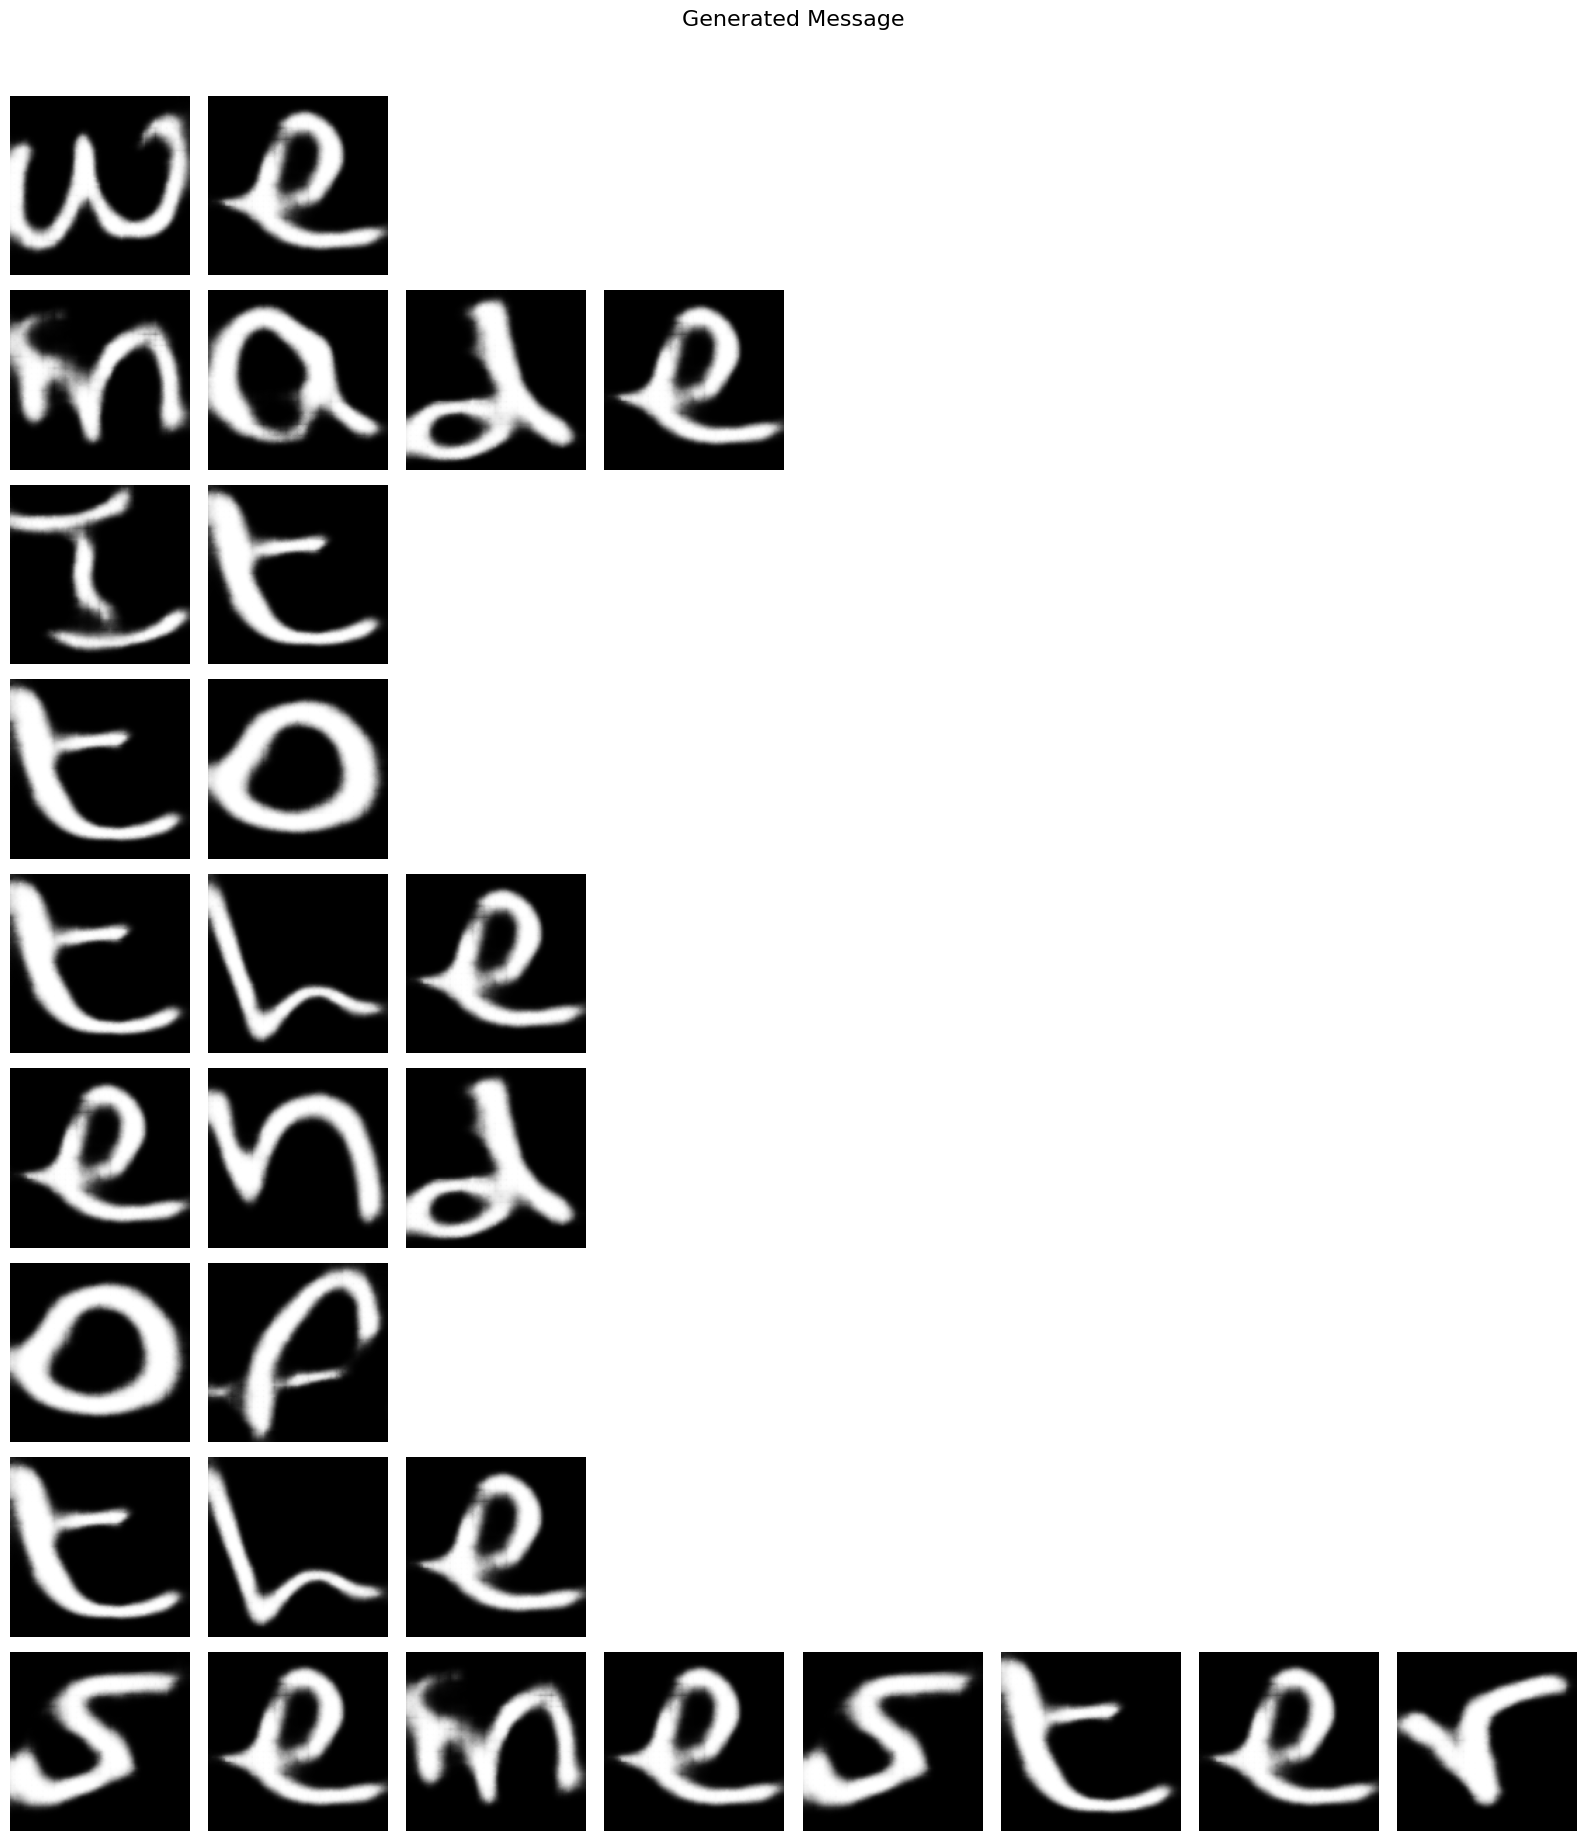

## References:

Handwriting Segmentation: https://medium.com/@maniksingh256/word-segmentation-from-handwritten-paragraphs-using-opencv-tools-6ba05dee13b8

Variational Autoencoders: https://asokraju.medium.com/part-1-variational-autoencoders-introduction-and-implementation-1ceb47a75cb5

GANs: https://www.tensorflow.org/tutorials/generative/dcgan